# imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import glob
import re
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# import sys
# sys.path.append('/root/digital-twin/wireless_digital_twin/')

import tensorflow as tf
print(tf.test.gpu_device_name())


import utils.utilfunc as uf
from utils.models import PlanNet, RouteNet
from utils.datagen_old import PlanDataGen, get_output_format
import utils.datagen as dg

2022-12-27 15:38:08.667677: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-27 15:38:08.772498: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-27 15:38:09.967824: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriat

/device:GPU:0


# Config Files and Data Loaders

In [23]:
# abidata = '/root/digital-twin/digi_twin_summer_wireless_dataset-e3cce9c3860f1c1f3de8a0dcb5c744bb16ee4f34/data_split_clean'
# abidata2 = '/root/digital-twin/digi_twin_summer_wireless_dataset-e3cce9c3860f1c1f3de8a0dcb5c744bb16ee4f34/dataset-2'

config  = uf.PathConfigParser('./configs/config.ini').as_dict()
hparams = dict(**config['GNN'], **config['LearningParams'])

datagens, datasets = dg.get_data_gens_sets(config)
config

<class 'networkx.utils.decorators.argmap'> compilation 9:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/root/digital-twin/wireless_digital_twin/utils/datagen.py:238: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(self.graph_topology_undirected)


{'Paths': {'data': ['./dataset/NSFNet_routing_1'],
  'graph': ['./dataset/nsfnet.txt'],
  'logs': ['./output/logs/'],
  'routing': ['paths1'],
  'trainon': ['delay']},
 'GNN': {'T': 2,
  'link_state_dim': 16,
  'path_state_dim': 32,
  'node_state_dim': 16,
  'readoutLayerSizes': [16, 32, 16],
  'edgeMLPLayerSizes': [8, 16, 32, 16, 8]},
 'LearningParams': {'epochs': 50,
  'learning_rate': 0.0001,
  'lr_decay_steps': 10000,
  'lr_decay_rate': 0.95,
  'batch_size': 32,
  'dropout_rate': 0.1,
  'l2': 0.1,
  'l2_2': 0.01,
  'learn_embedding': True}}

# Models

In [26]:

model = PlanNet(hparams, train_on=config['Paths']['trainon'])
# model = RouteNet(hparams, train_on = 'delay')
mclass = re.findall('\'.+\..+\.(.+)\'', str(model.__class__))[0] #<class 'utils.models.PlanNet'>

model.build()
opt = tf.keras.optimizers.Adam(learning_rate=hparams['learning_rate'], weight_decay=1e-4)
model.compile(optimizer="adam",#opt, 
              run_eagerly=False)

# save model
checkpoint_dir = os.path.join(config['Paths']['logs'][0], mclass, model.train_on)
print(checkpoint_dir)
os.makedirs(checkpoint_dir, exist_ok = True)
checkpoint_path = os.path.join(checkpoint_dir, "cp.ckpt")
csvlog_path = os.path.join(checkpoint_dir, "training.log")

# Create a callback that saves the model's weights
cp_early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, 
    mode='auto', baseline=None, restore_best_weights=True)
cp_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, save_weights_only=True, verbose=1)
cp_csv0 = tf.keras.callbacks.CSVLogger(
    csvlog_path, separator=',', append=True)


model(datagens['train'].__getitem__(0)[0])


./output/logs/PlanNet/delay


<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[-0.10836446],
       [-2.138773  ],
       [-0.04731093],
       [-0.02156108],
       [-2.025528  ],
       [-0.27536878],
       [-0.0467858 ],
       [-0.45767486],
       [-2.0237615 ],
       [-0.03079614]], dtype=float32)>

In [6]:
iters_per_epoch = 20
num_loops = 1
model.fit(
    x                = datasets['train'], 
    steps_per_epoch  = datagens['train'].__len__()//iters_per_epoch, 
    epochs           = iters_per_epoch * num_loops, 
    batch_size       = hparams['batch_size'],
    validation_data  = datasets['validate'], 
    validation_steps = datagens['validate'].__len__()//iters_per_epoch, 
    verbose   = True,
    callbacks = [cp_early_stop, cp_checkpoint, cp_csv0]
)

Epoch 1/20
<class 'dict'> <class 'dict'>
train_step | pred: Tensor("Any:0", shape=(), dtype=bool) (None, 1)
train_step | loss: Tensor("Any_1:0", shape=(), dtype=bool) Tensor("Mean_1:0", shape=(), dtype=float32)
<class 'dict'> <class 'dict'>
train_step | pred: Tensor("Any:0", shape=(), dtype=bool) (None, 1)
train_step | loss: Tensor("Any_1:0", shape=(), dtype=bool) Tensor("Mean_1:0", shape=(), dtype=float32)


<class 'networkx.utils.decorators.argmap'> compilation 9:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/root/digital-twin/wireless_digital_twin/utils/datagen.py:238: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(self.graph_topology_undirected)
2022-12-27 15:39:03.950286: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x411688d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-12-27 15:39:03.950351: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2022-12-27 15:39:03.950367: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2022-12-27 15:39:03.960967: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabli

692/693 [============================>.] - ETA: 0s - loss: 68056.7045 - label/mean/delay: 432.4608 - prediction/mean/delay: 352.0100{'n_paths': <tf.Tensor 'IteratorGetNext:7' shape=() dtype=int32>, 'n_links': <tf.Tensor 'IteratorGetNext:5' shape=() dtype=int32>, 'n_nodes': <tf.Tensor 'IteratorGetNext:6' shape=() dtype=int32>, 'n_total': <tf.Tensor 'IteratorGetNext:8' shape=() dtype=int32>, 'paths_to_links': <tf.Tensor 'IteratorGetNext:13' shape=(None,) dtype=int32>, 'links_to_paths': <tf.Tensor 'IteratorGetNext:4' shape=(None,) dtype=int32>, 'sequences_paths_links': <tf.Tensor 'IteratorGetNext:17' shape=(None,) dtype=int32>, 'links_to_nodes': <tf.Tensor 'IteratorGetNext:3' shape=(None,) dtype=int32>, 'nodes_to_links': <tf.Tensor 'IteratorGetNext:10' shape=(None,) dtype=int32>, 'sequences_links_nodes': <tf.Tensor 'IteratorGetNext:15' shape=(None,) dtype=int32>, 'paths_to_nodes': <tf.Tensor 'IteratorGetNext:14' shape=(None,) dtype=int32>, 'nodes_to_paths': <tf.Tensor 'IteratorGetNext:11'

<class 'networkx.utils.decorators.argmap'> compilation 9:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/root/digital-twin/wireless_digital_twin/utils/datagen.py:238: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(self.graph_topology_undirected)



Epoch 1: saving model to ./output/logs/PlanNet/delay/cp.ckpt
693/693 [==============================] - 28s 31ms/step - loss: 67939.8423 - label/mean/delay: 432.4768 - prediction/mean/delay: 352.3348 - val_loss: 8641.9629 - val_label/mean/delay: 389.4000 - val_prediction/mean/delay: 430.8033
Epoch 2/20
692/693 [============================>.] - ETA: 0s - loss: 23290.6968 - label/mean/delay: 431.4685 - prediction/mean/delay: 419.6141

<class 'networkx.utils.decorators.argmap'> compilation 9:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/root/digital-twin/wireless_digital_twin/utils/datagen.py:238: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(self.graph_topology_undirected)



Epoch 2: saving model to ./output/logs/PlanNet/delay/cp.ckpt
693/693 [==============================] - 21s 30ms/step - loss: 23273.8088 - label/mean/delay: 431.3156 - prediction/mean/delay: 419.6212 - val_loss: 8281.2090 - val_label/mean/delay: 389.4000 - val_prediction/mean/delay: 412.1395
Epoch 3/20
692/693 [============================>.] - ETA: 0s - loss: 29814.7161 - label/mean/delay: 433.3163 - prediction/mean/delay: 422.8955

<class 'networkx.utils.decorators.argmap'> compilation 9:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/root/digital-twin/wireless_digital_twin/utils/datagen.py:238: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(self.graph_topology_undirected)



Epoch 3: saving model to ./output/logs/PlanNet/delay/cp.ckpt
693/693 [==============================] - 21s 31ms/step - loss: 29778.1357 - label/mean/delay: 433.3304 - prediction/mean/delay: 422.8394 - val_loss: 7350.9795 - val_label/mean/delay: 389.4000 - val_prediction/mean/delay: 421.1734
Epoch 4/20
693/693 [==============================] - ETA: 0s - loss: 22562.0569 - label/mean/delay: 431.9022 - prediction/mean/delay: 421.9418

<class 'networkx.utils.decorators.argmap'> compilation 9:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/root/digital-twin/wireless_digital_twin/utils/datagen.py:238: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(self.graph_topology_undirected)



Epoch 4: saving model to ./output/logs/PlanNet/delay/cp.ckpt
693/693 [==============================] - 21s 31ms/step - loss: 22556.8770 - label/mean/delay: 432.0004 - prediction/mean/delay: 422.0063 - val_loss: 7732.1455 - val_label/mean/delay: 389.4000 - val_prediction/mean/delay: 436.4604
Epoch 5/20
692/693 [============================>.] - ETA: 0s - loss: 19521.4022 - label/mean/delay: 431.5986 - prediction/mean/delay: 422.6647

<class 'networkx.utils.decorators.argmap'> compilation 9:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/root/digital-twin/wireless_digital_twin/utils/datagen.py:238: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(self.graph_topology_undirected)



Epoch 5: saving model to ./output/logs/PlanNet/delay/cp.ckpt
693/693 [==============================] - 21s 31ms/step - loss: 19623.5146 - label/mean/delay: 431.4156 - prediction/mean/delay: 422.6794 - val_loss: 5786.5322 - val_label/mean/delay: 389.4000 - val_prediction/mean/delay: 388.0984
Epoch 6/20
692/693 [============================>.] - ETA: 0s - loss: 19951.7344 - label/mean/delay: 432.0565 - prediction/mean/delay: 422.6731

<class 'networkx.utils.decorators.argmap'> compilation 9:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/root/digital-twin/wireless_digital_twin/utils/datagen.py:238: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(self.graph_topology_undirected)



Epoch 6: saving model to ./output/logs/PlanNet/delay/cp.ckpt
693/693 [==============================] - 21s 31ms/step - loss: 19932.4416 - label/mean/delay: 431.9163 - prediction/mean/delay: 422.6192 - val_loss: 7566.4390 - val_label/mean/delay: 389.4000 - val_prediction/mean/delay: 408.3356
Epoch 7/20
693/693 [==============================] - ETA: 0s - loss: 18881.9843 - label/mean/delay: 429.8179 - prediction/mean/delay: 420.4542

<class 'networkx.utils.decorators.argmap'> compilation 9:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/root/digital-twin/wireless_digital_twin/utils/datagen.py:238: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(self.graph_topology_undirected)



Epoch 7: saving model to ./output/logs/PlanNet/delay/cp.ckpt
693/693 [==============================] - 21s 31ms/step - loss: 18861.7535 - label/mean/delay: 429.8033 - prediction/mean/delay: 420.4474 - val_loss: 7799.5654 - val_label/mean/delay: 389.4000 - val_prediction/mean/delay: 396.0985
Epoch 8/20
692/693 [============================>.] - ETA: 0s - loss: 16644.4436 - label/mean/delay: 429.4488 - prediction/mean/delay: 421.5817

<class 'networkx.utils.decorators.argmap'> compilation 9:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/root/digital-twin/wireless_digital_twin/utils/datagen.py:238: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(self.graph_topology_undirected)



Epoch 8: saving model to ./output/logs/PlanNet/delay/cp.ckpt
693/693 [==============================] - 21s 31ms/step - loss: 16717.0215 - label/mean/delay: 429.7012 - prediction/mean/delay: 421.6012 - val_loss: 7576.5322 - val_label/mean/delay: 389.4000 - val_prediction/mean/delay: 389.8265
Epoch 9/20
692/693 [============================>.] - ETA: 0s - loss: 20061.3687 - label/mean/delay: 430.7569 - prediction/mean/delay: 422.5373

<class 'networkx.utils.decorators.argmap'> compilation 9:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/root/digital-twin/wireless_digital_twin/utils/datagen.py:238: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(self.graph_topology_undirected)



Epoch 9: saving model to ./output/logs/PlanNet/delay/cp.ckpt
693/693 [==============================] - 21s 31ms/step - loss: 20024.1109 - label/mean/delay: 430.8415 - prediction/mean/delay: 422.5852 - val_loss: 7415.1743 - val_label/mean/delay: 389.4000 - val_prediction/mean/delay: 415.7963
Epoch 10/20
692/693 [============================>.] - ETA: 0s - loss: 17578.4265 - label/mean/delay: 428.8741 - prediction/mean/delay: 421.3121

<class 'networkx.utils.decorators.argmap'> compilation 9:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/root/digital-twin/wireless_digital_twin/utils/datagen.py:238: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(self.graph_topology_undirected)



Epoch 10: saving model to ./output/logs/PlanNet/delay/cp.ckpt
693/693 [==============================] - 21s 31ms/step - loss: 17553.0200 - label/mean/delay: 428.7509 - prediction/mean/delay: 421.2633 - val_loss: 8588.7207 - val_label/mean/delay: 389.4000 - val_prediction/mean/delay: 412.8358
Epoch 11/20
692/693 [============================>.] - ETA: 0s - loss: 19041.7360 - label/mean/delay: 430.7039 - prediction/mean/delay: 423.0724

<class 'networkx.utils.decorators.argmap'> compilation 9:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/root/digital-twin/wireless_digital_twin/utils/datagen.py:238: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(self.graph_topology_undirected)



Epoch 11: saving model to ./output/logs/PlanNet/delay/cp.ckpt
693/693 [==============================] - 22s 31ms/step - loss: 19011.7776 - label/mean/delay: 430.5212 - prediction/mean/delay: 422.9414 - val_loss: 8287.6504 - val_label/mean/delay: 389.4000 - val_prediction/mean/delay: 390.1650
Epoch 12/20
692/693 [============================>.] - ETA: 0s - loss: 17077.9936 - label/mean/delay: 431.2902 - prediction/mean/delay: 422.8754

<class 'networkx.utils.decorators.argmap'> compilation 9:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/root/digital-twin/wireless_digital_twin/utils/datagen.py:238: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(self.graph_topology_undirected)



Epoch 12: saving model to ./output/logs/PlanNet/delay/cp.ckpt
693/693 [==============================] - 21s 31ms/step - loss: 17061.0291 - label/mean/delay: 431.3124 - prediction/mean/delay: 422.9232 - val_loss: 9938.9189 - val_label/mean/delay: 389.4000 - val_prediction/mean/delay: 435.2949
Epoch 13/20
692/693 [============================>.] - ETA: 0s - loss: 17995.6434 - label/mean/delay: 431.8662 - prediction/mean/delay: 424.7903

<class 'networkx.utils.decorators.argmap'> compilation 9:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/root/digital-twin/wireless_digital_twin/utils/datagen.py:238: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(self.graph_topology_undirected)



Epoch 13: saving model to ./output/logs/PlanNet/delay/cp.ckpt
693/693 [==============================] - 21s 31ms/step - loss: 18010.8483 - label/mean/delay: 431.9651 - prediction/mean/delay: 424.7952 - val_loss: 10750.9375 - val_label/mean/delay: 389.4000 - val_prediction/mean/delay: 428.7121
Epoch 14/20
693/693 [==============================] - ETA: 0s - loss: 21862.6949 - label/mean/delay: 433.3003 - prediction/mean/delay: 425.9093

<class 'networkx.utils.decorators.argmap'> compilation 9:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/root/digital-twin/wireless_digital_twin/utils/datagen.py:238: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(self.graph_topology_undirected)



Epoch 14: saving model to ./output/logs/PlanNet/delay/cp.ckpt
693/693 [==============================] - 21s 31ms/step - loss: 21872.7710 - label/mean/delay: 433.3950 - prediction/mean/delay: 425.8508 - val_loss: 8831.1328 - val_label/mean/delay: 389.4000 - val_prediction/mean/delay: 424.1789
Epoch 15/20
693/693 [==============================] - ETA: 0s - loss: 18731.2991 - label/mean/delay: 432.1453 - prediction/mean/delay: 424.6152

<class 'networkx.utils.decorators.argmap'> compilation 9:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/root/digital-twin/wireless_digital_twin/utils/datagen.py:238: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(self.graph_topology_undirected)



Epoch 15: saving model to ./output/logs/PlanNet/delay/cp.ckpt
693/693 [==============================] - 21s 31ms/step - loss: 18729.5125 - label/mean/delay: 432.1768 - prediction/mean/delay: 424.6218 - val_loss: 7750.8857 - val_label/mean/delay: 389.4000 - val_prediction/mean/delay: 409.3198


In [11]:
from tqdm.auto import tqdm
import time 

metrics_mae = []
delay_true = []
delay_pred = []
cnt = 0
for inp, lab in datagens['validate']:
    t_start = time.time()
    
    delay_true.append(lab[model.train_on])
    delay_pred.append(model(inp).numpy().squeeze())
    
    t_end = time.time()
    cnt +=1
    print(cnt, 'used time {}s'.format(t_end - t_start), end = '\r')
    
delay_true = np.concatenate(delay_true)
delay_pred = np.concatenate(delay_pred)
metrics_mae = np.abs(delay_pred - delay_true)

print("MAE = {:.2f} ({:.2f}), Err% = {:.2%} ({:.2%})".format(
    np.nanmean(metrics_mae), np.nanstd(metrics_mae),
    np.nanmean(err[~np.isinf(err)]), np.nanstd(err[~np.isinf(err)]), 
))

MAE = 85.88 (89.47), Err% = 23.43% (28.08%)


In [10]:
delay_true.mean(), delay_true.std()

(430.57068, 251.9588)

In [ ]:
delay_true, delay_pred
# plt.plot(delay_pred[:200])

In [ ]:
metrics_mae = np.abs(delay_pred - delay_true)

(metrics_mae/delay_true).mean(), (metrics_mae/delay_true).std()

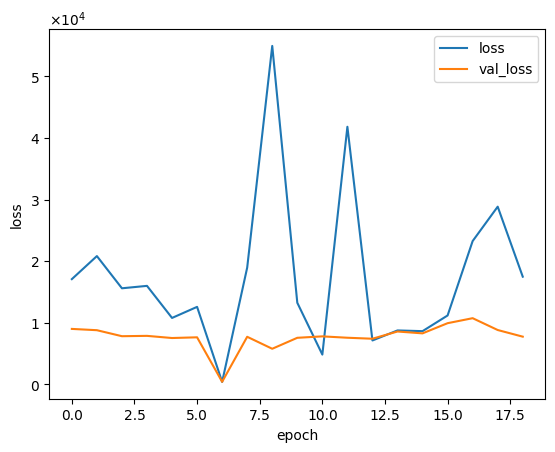

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)
pd.read_csv(csvlog_path)[['loss', 'val_loss']].plot(ax=ax)

plt.legend()
plt.ylabel('loss')
plt.xlabel('epoch')

from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.yaxis.set_major_formatter(formatter) 

In [ ]:
csvlog_path

In [ ]:
# Test1
model.evaluate(valid_data_generator)

In [ ]:
# Tetst2
r_.evaluate(test_data_generator)